In [31]:
import numpy as np
import pandas as pd
import sklearn as sk

import psycopg2
import pystan

import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.style
matplotlib.style.use('ggplot')
%matplotlib inline

In [122]:
import sklearn.metrics
import sklearn.preprocessing
import sklearn.linear_model

In [2]:
# create a database connection
sqluser = 'mimic'
dbname = 'mimic'
schema_name = 'mimiciii'

cur = None

In [3]:
if cur: 
    cur.close()
    con.close()

con = psycopg2.connect(dbname = dbname, user = sqluser)
cur = con.cursor()
cur.execute('SET search_path to ' + schema_name)

In [25]:
query = \
"""
SELECT * FROM echo_filtered; 
"""
ef = pd.read_sql_query(query, con)
ef['mortality_30d'] = ef['ea_days_after_discharge_death'] <= 30
ef.head()

,row_id,icustay_id,hadm_id,subject_id,age_at_intime,gender,height,weight,bmi,ethnicity,...,fl_day1_balance_ml,fl_day2_input_ml,fl_day2_output_ml,fl_day2_balance_ml,fl_day3_input_ml,fl_day3_output_ml,fl_day3_balance_ml,most_recent_hadm,first_echo,mortality_30d
0,67805,280987,182104,36,25443 days 10:29:14,M,NaN,NaN,NaN,WHITE,...,1116.0,508.0,1201.0,-693.0,NaN,NaN,NaN,1,1,False
1,67118,216609,116009,62,25097 days 00:20:44,M,68.0,150.0,22.804931,PATIENT DECLINED TO ANSWER,...,2083.0,505.0,1525.0,-1020.0,335.5,730.0,-394.5,1,1,False
2,80320,281607,112086,75,28018 days 10:35:50,F,NaN,NaN,NaN,WHITE,...,1630.0,12.0,1475.0,-1463.0,NaN,NaN,NaN,1,1,False
3,80083,206222,190243,86,16521 days 11:51:54,F,NaN,NaN,NaN,WHITE,...,1813.0,1006.0,1430.0,-424.0,NaN,NaN,NaN,1,1,False
4,82745,232514,114585,115,27643 days 13:22:28,F,63.0,207.0,36.664399,WHITE,...,2255.0,1105.5,1466.0,-360.5,NaN,NaN,NaN,1,1,False


In [20]:
[c for c in ef.columns if 'ea' in c]

['ex_congestive_heart_failure',
 'ex_valvular_disease',
 'ex_liver_disease',
 'apsiii_creatinine_score',
 'ea_first_careunit',
 'ea_age',
 'ea_age_of_death',
 'ea_days_after_discharge_death',
 'ea_status',
 'ea_tv_pulm_htn',
 'ea_tv_tr',
 'ea_lv_cavity',
 'ea_lv_diastolic',
 'ea_lv_systolic',
 'ea_lv_wall',
 'ea_rv_cavity',
 'ea_rv_diastolic_fluid',
 'ea_rv_systolic',
 'ea_rv_wall',
 'lab_creatinine']

I want to construct a new dataframe with all the information for modeling. The main question is how lv_systolic interacts with fluid management to determine 30-day mortality. I may be interested in only extracting echos which fall into the -1 or 3 category. That givs us only about 134 echos. 

Note that `apsiii` is the apsiii score, there is also `apsiii_prob`, that calculates the probability of hospital mortality, and various other scores. 

The simplest of models: 

In [116]:
data = ef.loc[ef['ea_lv_systolic'] >= -1,
        ['ea_lv_systolic', 'fl_day1_balance_ml', 
         'ex_congestive_heart_failure', 'mech_vent', 'apsiii', 
         'mortality_30d']].dropna()
data['ea_lv_systolic'] = (data['ea_lv_systolic'] + 2).astype(int)
data['mortality_30d'] = data['mortality_30d'].apply(lambda v: 1 if v else 0)
data['fl_day1_balance_ml'] = sk.preprocessing.scale(data['fl_day1_balance_ml'])
print(data.shape)
data.head()

(1716, 6)


,ea_lv_systolic,fl_day1_balance_ml,ex_congestive_heart_failure,mech_vent,apsiii,mortality_30d
0,3,-0.213822,0,0,18,0
1,2,0.171148,0,0,45,0
2,2,-0.009194,0,1,27,0
3,2,0.063659,0,0,26,0
4,1,0.239623,1,1,64,0


In [118]:
model = """
data {
    int<lower=0> N;
    int<lower=0> n_cats; 
    
    int<lower=0,upper=n_cats> ea_lv_systolic[N];
    vector[N] fl_day1_balance_ml;
    vector<lower=0,upper=1>[N] ex_congestive_heart_failure;
    vector<lower=0,upper=1>[N] mech_vent;
    vector[N] apsiii;
    int<lower=0,upper=1> y[N]; 
}
parameters {
    vector[5] beta; 
    vector[n_cats] a; 
    vector[n_cats] b;
    
    real<lower=0,upper=100> sigma_a;
    real<lower=0,upper=100> sigma_b; 
}
transformed parameters {
    vector[N] y_hat;
    for (i in 1:N)
        y_hat[i] <- beta[1] 
            + beta[2] * fl_day1_balance_ml[i]
            + beta[3] * ex_congestive_heart_failure[i]
            + beta[4] * mech_vent[i]
            + beta[5] * apsiii[i]
            + a[ea_lv_systolic[i]] 
            + b[ea_lv_systolic[i]] * ex_congestive_heart_failure[i];
}
model {
    a ~ normal(0, sigma_a);
    b ~ normal(0, sigma_b); 
    y ~ bernoulli_logit(y_hat);
}
"""
data_ = {
    'N': len(data), 
    'n_cats': data['ea_lv_systolic'].max(),
    'ea_lv_systolic': data['ea_lv_systolic'].values, 
    'fl_day1_balance_ml': sk.preprocessing.scale(data['fl_day1_balance_ml'].values), 
    'ex_congestive_heart_failure': data['ex_congestive_heart_failure'].values, 
    'mech_vent': data['mech_vent'].values,
    'apsiii': data['apsiii'].values,
    'y': data['mortality_30d'].values
}
fit = pystan.stan(
    model_code = model, 
    data = data_, 
    iter = 1000, chains = 2
)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_701fe5a56457c42086be2063f6c98ca1 NOW.
/Users/yhtgrace/anaconda3/envs/patches/lib/python3.5/multiprocessing/reduction.py:50: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  cls(buf, protocol).dump(obj)
/Users/yhtgrace/anaconda3/envs/patches/lib/python3.5/multiprocessing/reduction.py:50: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  cls(buf, protocol).dump(obj)


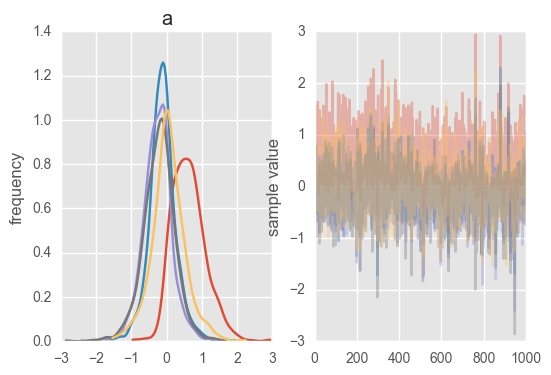

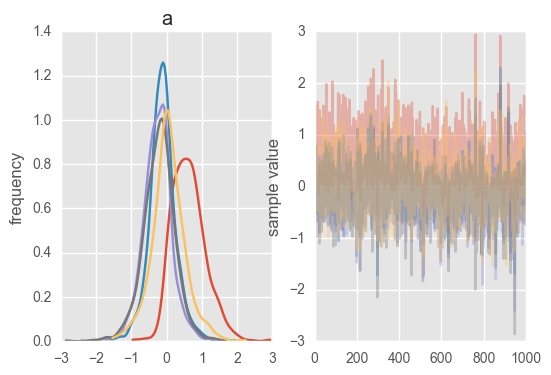

In [119]:
fit.plot(['a'])

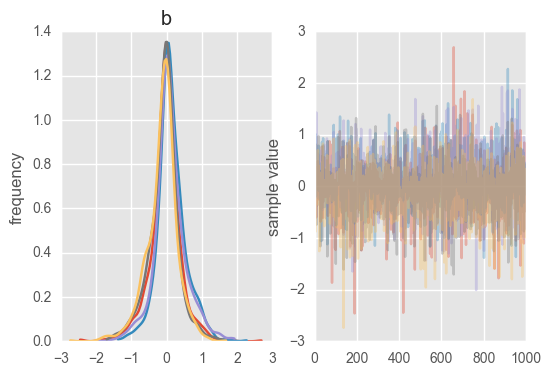

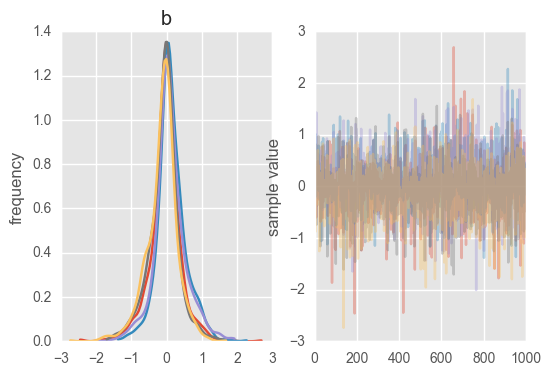

In [120]:
fit.plot(['b'])

In [124]:
print(fit)

Inference for Stan model: anon_model_701fe5a56457c42086be2063f6c98ca1.
2 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=1000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta[0]      -5.13    0.01   0.47  -6.05  -5.41  -5.12  -4.84  -4.22   1000   1.01
beta[1]      -0.32  2.6e-3   0.08  -0.48  -0.38  -0.32  -0.27  -0.16   1000   1.01
beta[2]       1.17    0.01   0.41   0.28   0.94    1.2   1.42   1.96   1000   1.01
beta[3]       1.13  5.8e-3   0.18   0.77   1.01   1.13   1.25    1.5   1000    1.0
beta[4]       0.05  1.1e-4 3.6e-3   0.04   0.04   0.05   0.05   0.05   1000    1.0
a[0]          0.62    0.02   0.48  -0.11   0.28   0.58    0.9   1.66   1000   1.02
a[1]         -0.12    0.01   0.39  -0.91  -0.33  -0.12   0.07   0.72   1000   1.01
a[2]         -0.26    0.01   0.42  -1.09   -0.5  -0.25  -0.02   0.61   1000   1.01
a[3]         -0.22    0.01   0.46  -1.16  -0.49  -0.19   0.04   0.

In [107]:
fit['beta'].mean(axis = 0)

array([ -4.95082015e+00,  -1.25385364e-04,   1.27395389e+00,
         1.11759044e+00,   4.67830935e-02])

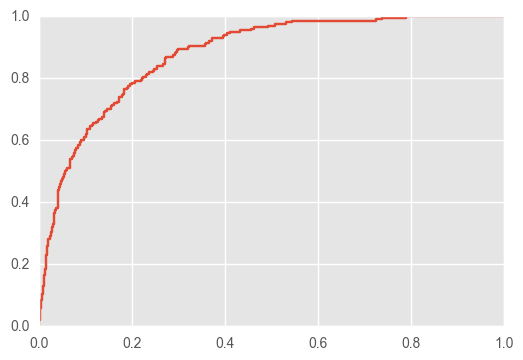

In [161]:
import sklearn as sk
import sklearn.metrics

sk.metrics.roc_auc_score(data['mortality_30d'].values, fit['y_hat'].mean(axis = 0))
fpr, tpr, _ = sk.metrics.roc_curve(data['mortality_30d'].values, fit['y_hat'].mean(axis = 0))
plt.plot(fpr, tpr)

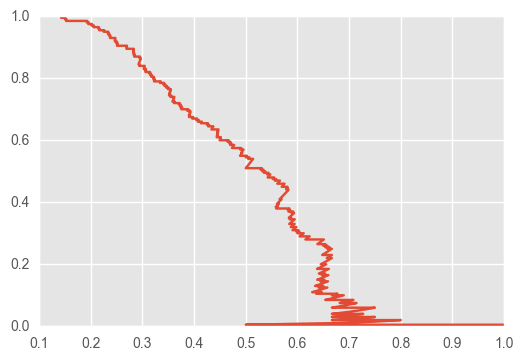

In [163]:
precision, recall, _ = sk.metrics.precision_recall_curve(data['mortality_30d'].values, fit['y_hat'].mean(axis = 0))
plt.plot(precision, recall)

In [110]:
pd.Series(data['mortality_30d']).value_counts() / len(data)

0    0.88345
1    0.11655
Name: mortality_30d, dtype: float64

Also looking at the distributions, 

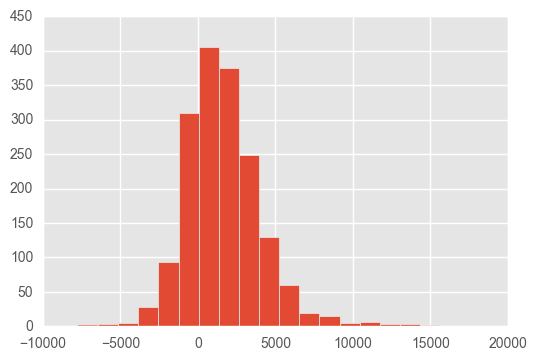

In [112]:
data['fl_day1_balance_ml'].hist(bins = 20)

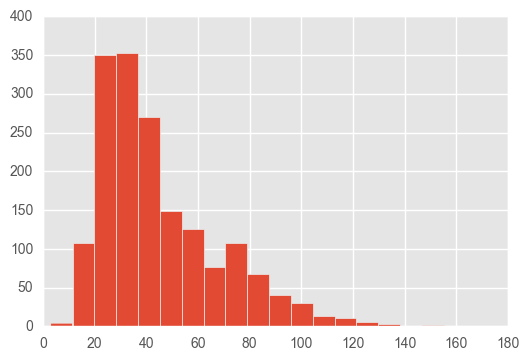

In [113]:
data['apsiii'].hist(bins = 20)

See if sklearn agrees, with a simple linear model or otherwise. 

In [126]:
data.head()

,ea_lv_systolic,fl_day1_balance_ml,ex_congestive_heart_failure,mech_vent,apsiii,mortality_30d
0,3,-0.213822,0,0,18,0
1,2,0.171148,0,0,45,0
2,2,-0.009194,0,1,27,0
3,2,0.063659,0,0,26,0
4,1,0.239623,1,1,64,0


In [158]:
onehot = sk.preprocessing.OneHotEncoder(sparse = False).fit_transform(data[['ea_lv_systolic']])
X = np.hstack([onehot, data[['fl_day1_balance_ml']].values])
X = np.hstack([X, data[['ex_congestive_heart_failure', 'mech_vent', 'apsiii']]])
y = data['mortality_30d'].values

model = sk.linear_model.LogisticRegressionCV()
model.fit(X, y)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [157]:
sk.metrics.roc_auc_score(y, model.predict_log_proba(X)[:,1])

0.87418535620052762